# TMDB Movie Data Analysis Pipeline

### Overview

The project is a PySpark-based data engineering project that fetches movie data from the TMDB API, cleans and preprocesses it, computes analytical metrics, and generates visualizations to explore trends in movie performance. The pipeline processes data for a list of movie IDs, producing cleaned datasets, computed metrics (e.g., ROI, profit), and visualizations (e.g., revenue vs. budget, franchise vs. standalone comparisons).

**Key Objectives**:

- Fetch raw movie data from the TMDB API.
- Clean and preprocess data for analysis (e.g., handle JSON fields).
- Compute metrics like profit and ROI.
- Visualize trends and comparisons (e.g., genre ROI, yearly performance).

In [1]:
# Import neccesary libraries and modules
from pyspark.sql import SparkSession, DataFrame
from pyspark.sql.functions import *
from pyspark.sql.types import FloatType
from pathlib import Path
import logging
import json
import sys
sys.path.append(str(Path('../scripts')))
from config import MOVIE_IDS,TMDB_API_KEY,BASE_URL,RAW_DATA_DIR, PROCESSED_DATA_DIR
from api_fetch import initialize_spark, create_movie_dataframe
from data_cleaning import *
from analysis import *
from visualization import *
from pyspark.sql import functions as F
from pyspark.sql.types import StringType, IntegerType


In [2]:
# Configure logging for timestamp, level, and message
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [3]:
#Initialize Spark
spark = initialize_spark()

# Fetch data from source into a dataframe
raw_df = create_movie_dataframe(MOVIE_IDS, TMDB_API_KEY, BASE_URL, RAW_DATA_DIR, spark)
raw_df.show(5)

2025-04-24 23:27:24,756 - INFO - Spark session initialized with custom configurations
2025-04-24 23:27:24,818 - INFO - Loaded cached data from data\raw\raw_movies_20250424_192554.json
2025-04-24 23:27:24,834 - WARNING - Attempt 1 failed for movie ID 0: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/movie/0?api_key=98eb78059acf277a9397adb9a104b869&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000021EF6A4BAD0>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo failed)"))
2025-04-24 23:27:25,852 - WARNING - Attempt 2 failed for movie ID 0: HTTPSConnectionPool(host='api.themoviedb.org', port=443): Max retries exceeded with url: /3/movie/0?api_key=98eb78059acf277a9397adb9a104b869&append_to_response=credits (Caused by NameResolutionError("<urllib3.connection.HTTPSConnection object at 0x0000021EF6A61990>: Failed to resolve 'api.themoviedb.org' ([Errno 11001] getaddrinfo f

+-----+--------------------+---------------------+---------+--------------------+--------------------+------+---------+--------------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+--------------------+-----+------------+----------+--------------------+
|adult|       backdrop_path|belongs_to_collection|   budget|              genres|            homepage|    id|  imdb_id|origin_country|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|  status|             tagline|               title|video|vote_average|vote_count|             credits|
+-----+--------------------+---------------------+---------+--------------------+--------------------+------+---------+--------------+-----------------+

In [4]:
# df = spark.read.json("data/raw/raw_movies_20250424_155235.json")
# df.show(5)

In [5]:
# Create a copy of the raw data
df = raw_df.select("*")
df.show(5)

+-----+--------------------+---------------------+---------+--------------------+--------------------+------+---------+--------------+-----------------+--------------------+--------------------+----------+--------------------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+--------------------+-----+------------+----------+--------------------+
|adult|       backdrop_path|belongs_to_collection|   budget|              genres|            homepage|    id|  imdb_id|origin_country|original_language|      original_title|            overview|popularity|         poster_path|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|  status|             tagline|               title|video|vote_average|vote_count|             credits|
+-----+--------------------+---------------------+---------+--------------------+--------------------+------+---------+--------------+-----------------+

In [6]:
# Dop irrelevant column
columns_to_drop = ['adult', 'imdb_id', 'original_title', 'video', 'homepage']
print(f"Total number of columns before dropping irrelevant columns is: {len(df.columns)}")
df = df.drop(*columns_to_drop)
print(f"Total number of columns after dropping irreleveant columns is: {len(df.columns)}")
df.show(5)

Total number of columns before dropping irrelevant columns is: 27
Total number of columns after dropping irreleveant columns is: 22
+--------------------+---------------------+---------+--------------------+------+--------------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+--------------------+------------+----------+--------------------+
|       backdrop_path|belongs_to_collection|   budget|              genres|    id|origin_country|original_language|            overview|popularity|         poster_path|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|  status|             tagline|               title|vote_average|vote_count|             credits|
+--------------------+---------------------+---------+--------------------+------+--------------+-----------------+--------------------+----------+-

In [7]:
# Evaluate JSON-like columns
df = process_json_fields(df)
df.show(5)

2025-04-24 23:27:55,516 - INFO - Processing JSON-like columns and credits


+--------------------+---------------------+---------+--------------------+------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------+----------+-------+--------------------+--------+--------------------+--------------------+------------+----------+--------------------+---------+--------------------+---------+
|       backdrop_path|belongs_to_collection|   budget|              genres|    id|original_language|            overview|popularity|         poster_path|production_companies|production_countries|release_date|   revenue|runtime|    spoken_languages|  status|             tagline|               title|vote_average|vote_count|                cast|cast_size|            director|crew_size|
+--------------------+---------------------+---------+--------------------+------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------+----------+-------+-

In [8]:
# Inspect extracted columns
columns_to_inspect = [
            "belongs_to_collection", "genres", "spoken_languages",
            "production_countries", "production_companies", "director"
        ]
for column in columns_to_inspect:
    inspect_column(df, column)

Inspecting value counts for belongs_to_collection
+-----------------------------------+-----+
|belongs_to_collection              |count|
+-----------------------------------+-----+
|The Avengers Collection            |4    |
|Star Wars Collection               |2    |
|Jurassic Park Collection           |2    |
|NULL                               |2    |
|Frozen Collection                  |2    |
|Avatar Collection                  |1    |
|The Lion King (Reboot) Collection  |1    |
|The Fast and the Furious Collection|1    |
|Black Panther Collection           |1    |
|Harry Potter Collection            |1    |
|The Incredibles Collection         |1    |
+-----------------------------------+-----+

Inspecting value counts for genres
+-------------------------------------------------+-----+
|genres                                           |count|
+-------------------------------------------------+-----+
|Adventure | Action | Science Fiction             |3    |
|Action | Adventure | 

In [9]:
# Convert column datatypes
print(f"Datatypes of columns before conversion: {df.printSchema()}")
df = convert_data_types(df)
print(f"Datatypes of columns after conversion: {df.printSchema()}")

2025-04-24 23:28:39,574 - INFO - Converting data types


root
 |-- backdrop_path: string (nullable = true)
 |-- belongs_to_collection: string (nullable = true)
 |-- budget: long (nullable = true)
 |-- genres: string (nullable = true)
 |-- id: integer (nullable = true)
 |-- original_language: string (nullable = true)
 |-- overview: string (nullable = true)
 |-- popularity: double (nullable = true)
 |-- poster_path: string (nullable = true)
 |-- production_companies: string (nullable = true)
 |-- production_countries: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- revenue: long (nullable = true)
 |-- runtime: integer (nullable = true)
 |-- spoken_languages: string (nullable = true)
 |-- status: string (nullable = true)
 |-- tagline: string (nullable = true)
 |-- title: string (nullable = true)
 |-- vote_average: double (nullable = true)
 |-- vote_count: integer (nullable = true)
 |-- cast: string (nullable = true)
 |-- cast_size: integer (nullable = false)
 |-- director: string (nullable = true)
 |-- crew_size: integ

In [10]:
# Replace unrealistic values
df = replace_unrealistic_values(df)
df.show(5)

2025-04-24 23:28:39,732 - INFO - Replacing unrealistic values


+--------------------+---------------------+--------------------+------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------+-------+--------------------+--------+--------------------+--------------------+------------+----------+--------------------+---------+--------------------+---------+-----------+------------+
|       backdrop_path|belongs_to_collection|              genres|    id|original_language|            overview|popularity|         poster_path|production_companies|production_countries|release_date|runtime|    spoken_languages|  status|             tagline|               title|vote_average|vote_count|                cast|cast_size|            director|crew_size|budget_musd|revenue_musd|
+--------------------+---------------------+--------------------+------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------+-------+--------------

In [11]:
duplicates = df.groupBy(df.columns) \
               .count() \
               .filter("count > 1")

duplicates.show()

+-------------+---------------------+------+---+-----------------+--------+----------+-----------+--------------------+--------------------+------------+-------+----------------+------+-------+-----+------------+----------+----+---------+--------+---------+-----------+------------+-----+
|backdrop_path|belongs_to_collection|genres| id|original_language|overview|popularity|poster_path|production_companies|production_countries|release_date|runtime|spoken_languages|status|tagline|title|vote_average|vote_count|cast|cast_size|director|crew_size|budget_musd|revenue_musd|count|
+-------------+---------------------+------+---+-----------------+--------+----------+-----------+--------------------+--------------------+------------+-------+----------------+------+-------+-----+------------+----------+----+---------+--------+---------+-----------+------------+-----+
+-------------+---------------------+------+---+-----------------+--------+----------+-----------+--------------------+--------------

In [12]:
# Remove duplicates and drop rows with unknown 'id' or 'title'
df = remove_duplicates_and_invalid_rows(df)
df.show()

2025-04-24 23:28:51,122 - INFO - Removing duplicates and rows with missing id or title


+--------------------+---------------------+--------------------+------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------+-------+--------------------+--------+--------------------+--------------------+------------+----------+--------------------+---------+--------------------+---------+-----------+------------+
|       backdrop_path|belongs_to_collection|              genres|    id|original_language|            overview|popularity|         poster_path|production_companies|production_countries|release_date|runtime|    spoken_languages|  status|             tagline|               title|vote_average|vote_count|                cast|cast_size|            director|crew_size|budget_musd|revenue_musd|
+--------------------+---------------------+--------------------+------+-----------------+--------------------+----------+--------------------+--------------------+--------------------+------------+-------+--------------

In [13]:
# Keep only rows where at least 10 columns have non-NaN values
logger.info(f"Number of rows before filtering: {df.count()}")
df = filter_rows(df)
logger.info(f"Number of rows after filtering: {df.count()}")

2025-04-24 23:29:05,624 - INFO - Number of rows before filtering: 18
2025-04-24 23:29:05,625 - INFO - Filtering rows with at least 10 non-null columns and Released status
2025-04-24 23:29:12,321 - INFO - Number of rows after filtering: 18


In [14]:
# Reorder the columns
logger.info(f"DataFrame columns: {df.columns}")
df = reorder_columns(df)
df.show()

2025-04-24 23:29:12,339 - INFO - DataFrame columns: ['backdrop_path', 'belongs_to_collection', 'genres', 'id', 'original_language', 'overview', 'popularity', 'poster_path', 'production_companies', 'production_countries', 'release_date', 'runtime', 'spoken_languages', 'tagline', 'title', 'vote_average', 'vote_count', 'cast', 'cast_size', 'director', 'crew_size', 'budget_musd', 'revenue_musd']
2025-04-24 23:29:12,342 - INFO - Reordering columns: ['id', 'title', 'tagline', 'release_date', 'genres', 'belongs_to_collection', 'original_language', 'budget_musd', 'revenue_musd', 'production_companies', 'production_countries', 'vote_count', 'vote_average', 'popularity', 'runtime', 'overview', 'spoken_languages', 'poster_path', 'cast', 'cast_size', 'director', 'crew_size']


+------+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+--------------------+---------+
|    id|               title|             tagline|release_date|              genres|belongs_to_collection|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|                cast|cast_size|            director|crew_size|
+------+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+----

In [15]:
# Calculate profit_musd and roi 
df = df.withColumn("profit_musd", F.col("revenue_musd") - F.col("budget_musd"))
df = df.withColumn("roi", F.when(F.col("budget_musd") >= 10, 
        F.col("revenue_musd") / F.col("budget_musd"))
         .otherwise(None).cast(FloatType()))
df.show(5)

+-----+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+--------------------+--------------------+--------------------+--------------------+---------+-------------+---------+-----------+---------+
|   id|               title|             tagline|release_date|              genres|belongs_to_collection|original_language|budget_musd|revenue_musd|production_companies|production_countries|vote_count|vote_average|popularity|runtime|            overview|    spoken_languages|         poster_path|                cast|cast_size|     director|crew_size|profit_musd|      roi|
+-----+--------------------+--------------------+------------+--------------------+---------------------+-----------------+-----------+------------+--------------------+--------------------+----------+------------+----------+-------+-------------------

In [16]:
# Filter and rank movies
analysis_df = analyze_data(df)

2025-04-24 23:29:26,093 - INFO - Computing KPIs


Top 5 Movies by Revenue (MUSD):
+------+----------------------------+------------+
|id    |title                       |revenue_musd|
+------+----------------------------+------------+
|19995 |Avatar                      |2923.706    |
|299534|Avengers: Endgame           |2799.4392   |
|597   |Titanic                     |2264.1624   |
|140607|Star Wars: The Force Awakens|2068.2236   |
|299536|Avengers: Infinity War      |2052.415    |
+------+----------------------------+------------+

Top 5 Movies by Budget (MUSD):
+------+----------------------------+-----------+
|id    |title                       |budget_musd|
+------+----------------------------+-----------+
|99861 |Avengers: Age of Ultron     |365.0      |
|299534|Avengers: Endgame           |356.0      |
|299536|Avengers: Infinity War      |300.0      |
|420818|The Lion King               |260.0      |
|140607|Star Wars: The Force Awakens|245.0      |
+------+----------------------------+-----------+

Top 5 Movies by Profit (MU

2025-04-24 23:30:29,059 - INFO - Performing advanced filtering
2025-04-24 23:30:29,107 - INFO - Best-Rated Science Fiction Action Movies Starring Bruce Willis:


+------+----------------------+----------+
|id    |title                 |popularity|
+------+----------------------+----------+
|299536|Avengers: Infinity War|87.9166   |
|420818|The Lion King         |53.5223   |
|284054|Black Panther         |51.8631   |
|321612|Beauty and the Beast  |50.0247   |
|299534|Avengers: Endgame     |47.7377   |
+------+----------------------+----------+



2025-04-24 23:30:35,331 - INFO - Movies Starring Uma Thurman, Directed by Quentin Tarantino (Sorted by Runtime):


+-----+------------+----+
|title|vote_average|cast|
+-----+------------+----+
+-----+------------+----+



2025-04-24 23:30:41,642 - INFO - Comparing franchise vs. standalone
2025-04-24 23:30:41,714 - INFO - Franchise vs. Standalone Movie Performance:


+-----+-------+----+--------+
|title|runtime|cast|director|
+-----+-------+----+--------+
+-----+-------+----+--------+



2025-04-24 23:30:48,200 - INFO - Analyzing franchises
2025-04-24 23:30:48,266 - INFO - Most Successful Movie Franchises:


+----------+-----------------+----------+----------------+-----------------+-----------------+
|movie_type|mean_revenue_musd|median_roi|mean_budget_musd|mean_popularity  |mean_rating      |
+----------+-----------------+----------+----------------+-----------------+-----------------+
|Standalone|1765.13916015625 |7.9132247 |180.0           |47.77779960632324|7.438000000000001|
|Franchise |1682.641990661621|7.7086253 |219.875         |33.03605020046234|7.380437499999999|
+----------+-----------------+----------+----------------+-----------------+-----------------+



2025-04-24 23:30:54,943 - INFO - Analyzing directors
2025-04-24 23:30:55,024 - INFO - Most Successful Directors:


+-----------------------------------+-----------+-----------------+----------------+------------------+------------------+-----------------+
|belongs_to_collection              |movie_count|total_budget_musd|mean_budget_musd|total_revenue_musd|mean_revenue_musd |mean_rating      |
+-----------------------------------+-----------+-----------------+----------------+------------------+------------------+-----------------+
|The Avengers Collection            |4          |1241.0           |310.25          |7776.073486328125 |1944.0183715820312|7.870749999999999|
|Star Wars Collection               |2          |445.0            |222.5           |3400.9224853515625|1700.4612426757812|7.0195           |
|Jurassic Park Collection           |2          |320.0            |160.0           |2982.0037841796875|1491.0018920898438|6.6155           |
|Avatar Collection                  |1          |237.0            |237.0           |2923.7060546875   |2923.7060546875   |7.588            |
|Frozen Colle

2025-04-24 23:31:01,446 - INFO - All analysis tasks completed


+---------------+-----------+------------------+-----------+
|director       |movie_count|total_revenue_musd|mean_rating|
+---------------+-----------+------------------+-----------+
|James Cameron  |2          |5187.868408203125 |7.7465     |
|Joe Russo      |2          |4851.854248046875 |8.236      |
|Anthony Russo  |2          |4851.854248046875 |8.236      |
|Joss Whedon    |2          |2924.21923828125  |7.5055     |
|Chris Buck     |2          |2727.9024658203125|7.248      |
|Jennifer Lee   |2          |2727.9024658203125|7.248      |
|J.J. Abrams    |1          |2068.2236328125   |7.261      |
|Colin Trevorrow|1          |1671.5374755859375|6.693      |
|Jon Favreau    |1          |1662.0208740234375|7.11       |
|James Wan      |1          |1515.4000244140625|7.226      |
|Ryan Coogler   |1          |1349.926025390625 |7.373      |
|David Yates    |1          |1341.51123046875  |8.087      |
|Rian Johnson   |1          |1332.6988525390625|6.778      |
|J.A. Bayona    |1      

Data Visualization

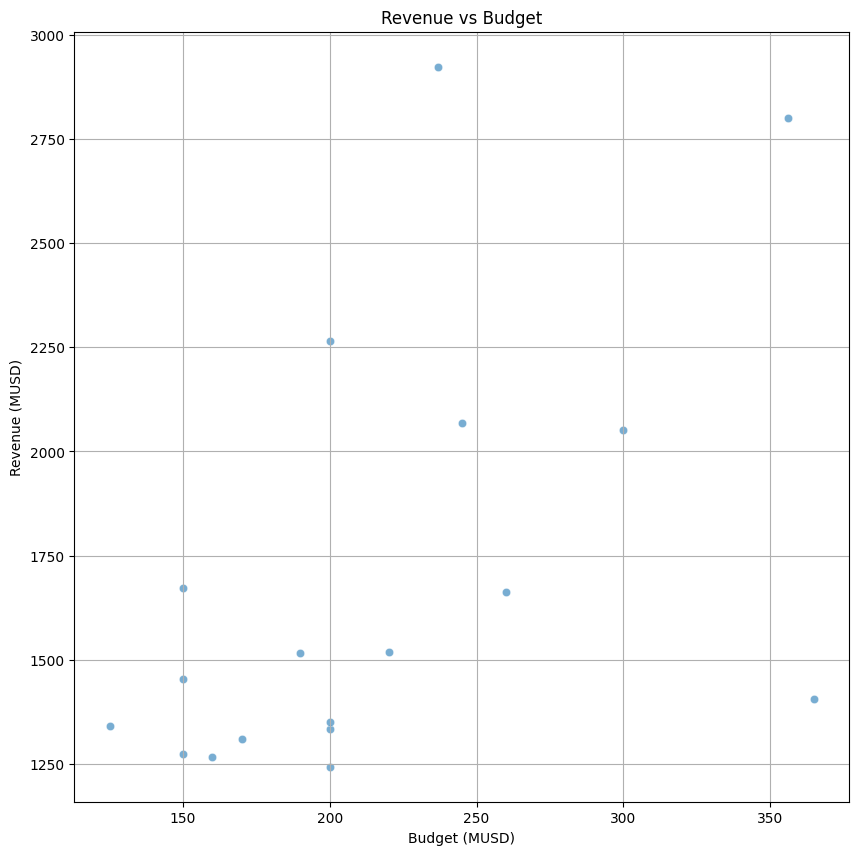

2025-04-24 23:31:14,935 - INFO - Saved revenue vs. budget plot to reports\figures\revenue_vs_budget.png


In [17]:
# Revenue vs budget
plot_revenue_vs_budget(df)

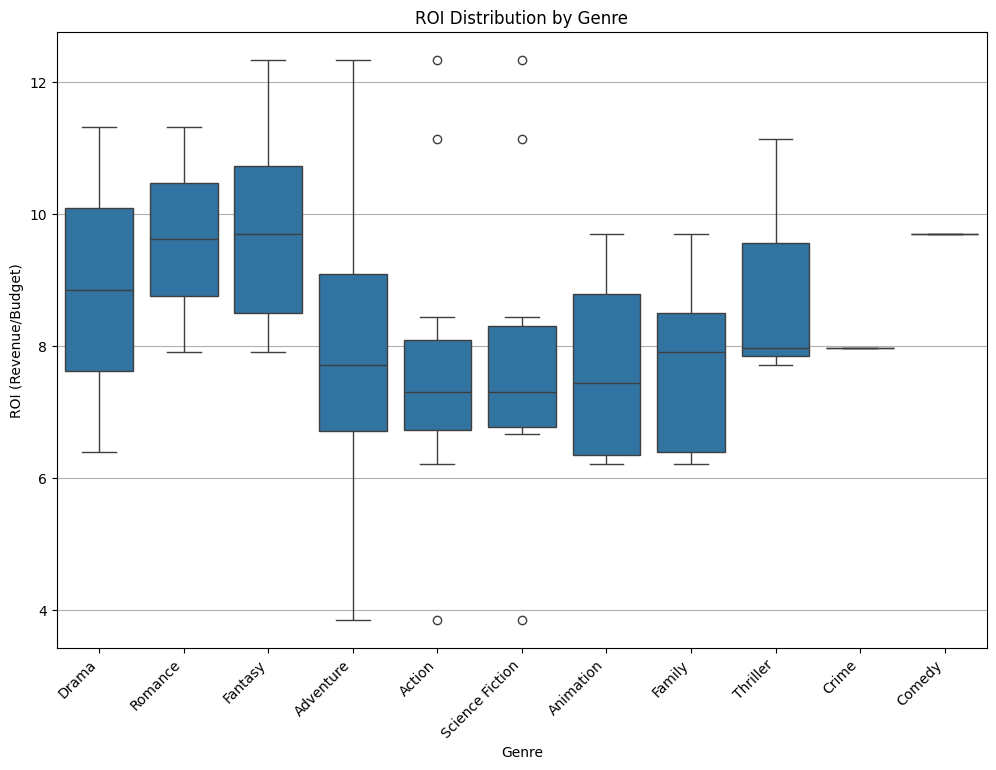

2025-04-24 23:31:27,289 - INFO - Saved ROI by genre plot to reports\figures\roi_by_genre.png


In [18]:
# ROI Distribution by genre
plot_roi_by_genre(df)

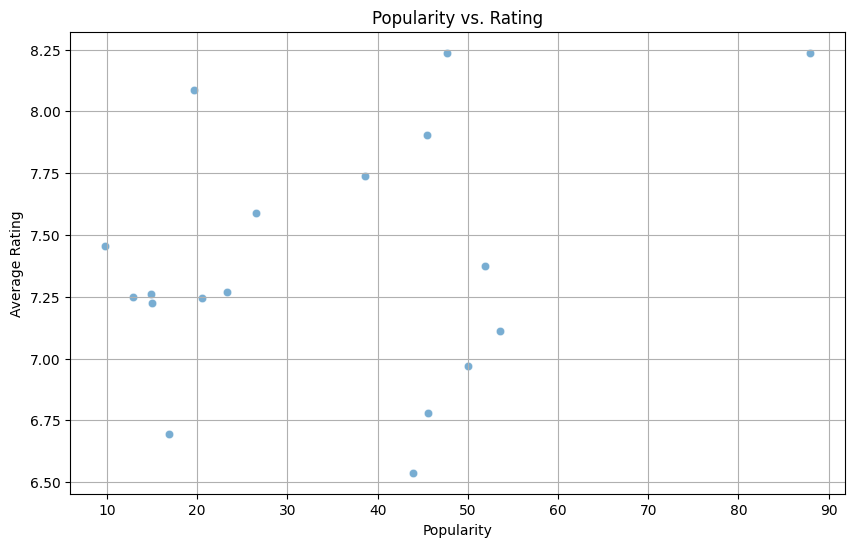

2025-04-24 23:31:39,883 - INFO - Saved popularity vs. rating plot to reports\figures\popularity_vs_rating.png


In [19]:
# Popularity vs Rating
plot_popularity_vs_rating(df) 

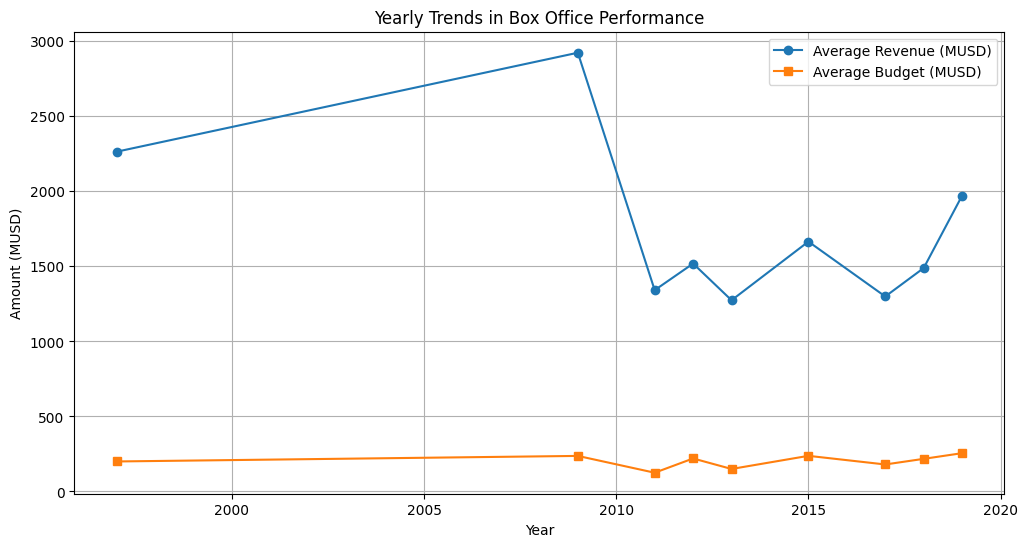

2025-04-24 23:31:52,323 - INFO - Saved yearly trends plot to reports\figures\yearly_trends.png


In [20]:
# Yearly trends in Box Office Performance
plot_yearly_trends(df)

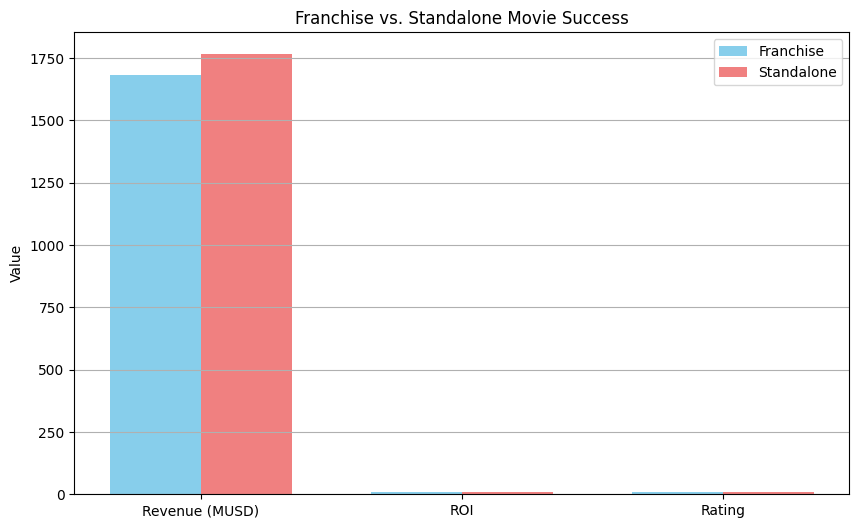

2025-04-24 23:32:04,784 - INFO - Saved franchise vs. standalone plot to reports\figures\franchise_vs_standalone.png


In [21]:
# Comparison of Franchise vs Standalone
plot_franchise_vs_standalone(df)